In [1]:
print('ok')

ok


In [14]:
import datetime
from typing import Dict, List, TypedDict, Optional, Any
from pydantic import BaseModel
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
import requests
import uuid
from langchain_core.messages import AIMessage
import os
from dotenv import load_dotenv
from IPython.display import Image, display
import copy

In [15]:
# LOAD ENVIRONMENT VARIABLES
load_dotenv()
required_env_vars = ["OPENAI_API_KEY", "WEATHER_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_PROJECT"]
for var in required_env_vars:
    if not os.getenv(var):
        raise EnvironmentError(f"Missing required environment variable: {var}")

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["WEATHER_API_KEY"] = os.getenv("WEATHER_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [16]:
# Pydantic Models
class Weather(BaseModel):
    date: str
    temperature: float
    condition: str

class Attraction(BaseModel):
    name: str
    description: str
    cost: float

class Restaurant(BaseModel):
    name: str
    cuisine: str
    avg_cost_per_person: float

class Activity(BaseModel):
    name: str
    description: str
    cost: float

class Transportation(BaseModel):
    mode: str
    cost_per_day: float

class Hotel(BaseModel):
    name: str
    daily_rate: float
    rating: float

class DayPlan(BaseModel):
    date: str
    attractions: List[Attraction]
    activities: List[Activity]
    meals: List[Restaurant]
    transportation: Transportation

class TripSummary(BaseModel):
    city: str
    start_date: str
    days: int
    summary: str

class Command(BaseModel):
    command_type: str
    update: Optional[Dict] = None
    goto: Optional[str] = None
    payload: Optional[Dict] = None
    sender: str
    recipient: str

class TravelState(TypedDict):
    city: str
    start_date: str
    days: int
    budget_range: tuple
    user_currency: str
    current_weather: Weather
    weather_forecast: List[Weather]
    attractions: List[Attraction]
    restaurants: List[Restaurant]
    activities: List[Activity]
    transportation: Transportation
    hotel: Hotel
    hotel_cost: float
    itinerary: List[DayPlan]
    daily_costs: List[float]
    total_cost_local: float
    daily_budget_local: float
    total_cost_user: float
    daily_budget_user: float
    summary: TripSummary
    session_id: str
    history: List[Dict]
    commands: List[Command]
    current_command: Optional[Command]
    response: Optional[Dict]

In [19]:
# Prompts
WEATHER_PROMPT = PromptTemplate(
    input_variables=["city", "days", "update", "command_type"],
    template="""
You are a Weather Agent in a travel planning system. Your role is to fetch current weather and forecast data.
Received command:
- Command type: {command_type}
- City: {city}
- Days: {days}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (get_current_weather, get_weather_forecast) to fetch weather data for the city and duration.
3. Return a structured response with weather data in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

ATTRACTIONS_PROMPT = PromptTemplate(
    input_variables=["city", "update", "command_type"],
    template="""
You are an Attractions Agent in a travel planning system. Your role is to find attractions, restaurants, activities, and transportation options.
Received command:
- Command type: {command_type}
- City: {city}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (search_attractions, search_restaurants, search_activities, search_transportation) to find relevant options in the city.
3. Return a structured response with the search results in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

HOTELS_PROMPT = PromptTemplate(
    input_variables=["city", "budget_range", "days", "update", "command_type"],
    template="""
You are a Hotels Agent in a travel planning system. Your role is to find hotels and estimate costs.
Received command:
- Command type: {command_type}
- City: {city}
- Budget range: {budget_range}
- Days: {days}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (search_hotels, estimate_hotel_cost) to find a hotel within the budget range and estimate the total cost.
3. Return a structured response with hotel details and cost in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

ITINERARY_PROMPT = PromptTemplate(
    input_variables=["city", "start_date", "days", "attractions", "activities", "restaurants", "transportation", "update", "command_type"],
    template="""
You are an Itinerary Agent in a travel planning system. Your role is to create a travel itinerary.
Received command:
- Command type: {command_type}
- City: {city}
- Start date: {start_date}
- Days: {days}
- Attractions: {attractions}
- Activities: {activities}
- Restaurants: {restaurants}
- Transportation: {transportation}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (create_day_plan, create_full_itinerary) to create a full itinerary with daily plans.
3. Return a structured response with the itinerary in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

EXPENSES_PROMPT = PromptTemplate(
    input_variables=["itinerary", "hotel_cost", "days", "update", "command_type"],
    template="""
You are an Expenses Agent in a travel planning system. Your role is to calculate trip costs.
Received command:
- Command type: {command_type}
- Itinerary: {itinerary}
- Hotel cost: {hotel_cost}
- Days: {days}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (calculate_daily_cost, calculate_total_cost, calculate_daily_budget) to calculate costs.
3. Return a structured response with cost details in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

CURRENCY_PROMPT = PromptTemplate(
    input_variables=["total_cost_local", "daily_budget_local", "user_currency", "update", "command_type"],
    template="""
You are a Currency Agent in a travel planning system. Your role is to convert costs to the user's currency.
Received command:
- Command type: {command_type}
- Total cost (local): {total_cost_local}
- Daily budget (local): {daily_budget_local}
- User currency: {user_currency}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (get_exchange_rate, convert_currency) to convert costs to the user's currency.
3. Return a structured response with converted costs in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

SUMMARY_PROMPT = PromptTemplate(
    input_variables=["city", "start_date", "days", "current_weather", "itinerary", "hotel", "total_cost_user", "daily_budget_user", "user_currency", "update", "command_type", "session_id"],
    template="""
You are a Summary Agent in a travel planning system. Your role is to create trip summaries or retrieve past plans.
Received command:
- Command type: {command_type}
- City: {city}
- Start date: {start_date}
- Days: {days}
- Current weather: {current_weather}
- Itinerary: {itinerary}
- Hotel: {hotel}
- Total cost (user currency): {total_cost_user}
- Daily budget (user currency): {daily_budget_user}
- User currency: {user_currency}
- Session ID: {session_id}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. If command_type is 'update_goto', use create_trip_summary to generate a summary.
3. If command_type is 'retrieve_plan', use retrieve_previous_plan to fetch the plan.
4. Return a structured response in JSON format.
5. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

BROKER_PROMPT = PromptTemplate(
    input_variables=["command_type", "payload", "update", "goto", "sender", "recipient"],
    template="""
You are a Message Broker Agent in a travel planning system, responsible for routing commands to the appropriate agents.
Received command:
- Command type: {command_type}
- Sender: {sender}
- Recipient: {recipient}
- Payload: {payload}
- Updates: {update}
- Goto: {goto}

Instructions:
1. If command_type is 'plan_trip', initialize the state with the payload and generate a sequence of commands.
2. If command_type is 'retrieve_plan', route to the summary agent.
3. If command_type is 'update_goto', route to the specified 'goto' agent with updates.
4. If command_type is 'response', store the response and proceed to the next command, ensuring no loopback to broker unless final.
5. Return a structured response with the next commands or an error in JSON format.

Execute the task and route the command appropriately.
"""
)

In [20]:
# Tools
@tool
def get_current_weather(city: str) -> Weather:
    """Fetch current weather for a city."""
    try:
        url = "https://api.openweathermap.org/data/2.5/weather"
        params = {"q": city, "appid": os.environ["WEATHER_API_KEY"]}
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return Weather(
            date=datetime.date.today().isoformat(),
            temperature=data.get("main", {}).get("temp", 20.0) - 273.15,  # Convert Kelvin to Celsius
            condition=data.get("weather", [{}])[0].get("description", "Clear")
        )
    except Exception as e:
        print(f"Error fetching current weather: {e}")
        return Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear")

@tool
def get_weather_forecast(city: str, days: int) -> List[Weather]:
    """Fetch weather forecast for a city."""
    try:
        url = "https://api.openweathermap.org/data/2.5/forecast"
        params = {"q": city, "appid": os.environ["WEATHER_API_KEY"], "cnt": days * 8}
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        forecast = []
        daily_data = {}
        for item in data.get("list", []):
            date = datetime.datetime.fromtimestamp(item["dt"]).date().isoformat()
            if date not in daily_data:
                daily_data[date] = {"temps": [], "conditions": []}
            daily_data[date]["temps"].append(item["main"]["temp"] - 273.15)
            daily_data[date]["conditions"].append(item["weather"][0]["description"])
        for i, (date, info) in enumerate(daily_data.items()):
            if i >= days:
                break
            avg_temp = sum(info["temps"]) / len(info["temps"]) if info["temps"] else 20.0
            condition = max(set(info["conditions"]), key=info["conditions"].count, default="Clear")
            forecast.append(Weather(date=date, temperature=avg_temp, condition=condition))
        return forecast[:days]
    except Exception as e:
        print(f"Error fetching weather forecast: {e}")
        return [Weather(date=(datetime.date.today() + datetime.timedelta(days=i)).isoformat(), temperature=20.0, condition="Clear") for i in range(days)]

@tool
def search_attractions(city: str) -> List[Attraction]:
    """Search for attractions in a city."""
    return [
        Attraction(name=f"{city} Museum", description="Historical museum", cost=15.0),
        Attraction(name=f"{city} Park", description="Scenic park", cost=0.0)
    ]

@tool
def search_restaurants(city: str) -> List[Restaurant]:
    """Search for restaurants in a city."""
    return [
        Restaurant(name=f"{city} Bistro", cuisine="Italian", avg_cost_per_person=20.0),
        Restaurant(name=f"{city} Cafe", cuisine="Local", avg_cost_per_person=15.0)
    ]

@tool
def search_activities(city: str) -> List[Activity]:
    """Search for activities in a city."""
    return [
        Activity(name=f"{city} Walking Tour", description="Guided city tour", cost=30.0),
        Activity(name=f"{city} Boat Ride", description="River cruise", cost=25.0)
    ]

@tool
def search_transportation(city: str) -> Transportation:
    """Search for transportation options in a city."""
    return Transportation(mode="Public Transit", cost_per_day=10.0)

@tool
def search_hotels(city: str, budget_range: tuple) -> Hotel:
    """Search for hotels in a city within budget range."""
    return Hotel(name=f"{city} Inn", daily_rate=100.0, rating=4.0)

@tool
def estimate_hotel_cost(hotel: Hotel, days: int) -> float:
    """Estimate hotel cost for the trip."""
    return hotel.daily_rate * days if hotel and days > 0 else 0.0

@tool
def get_exchange_rate(from_currency: str, to_currency: str) -> float:
    """Get exchange rate between two currencies."""
    try:
        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data.get("rates", {}).get(to_currency, 1.0)
    except Exception as e:
        print(f"Error fetching exchange rate: {e}")
        return 1.0

@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> float:
    """Convert amount from one currency to another."""
    exchange_rate = get_exchange_rate.invoke({
        "from_currency": from_currency,
        "to_currency": to_currency
    })
    return amount * exchange_rate

@tool
def calculate_daily_cost(
    attractions: List[Attraction],
    activities: List[Activity],
    meals: List[Restaurant],
    transportation: Transportation
) -> float:
    """Calculate daily cost."""
    return (
        sum(a.cost for a in attractions or []) +
        sum(a.cost for a in activities or []) +
        sum(r.avg_cost_per_person for r in meals or []) +
        (transportation.cost_per_day if transportation else 0.0)
    )

@tool
def calculate_total_cost(daily_costs: List[float], hotel_cost: float) -> float:
    """Calculate total trip cost."""
    return sum(daily_costs or []) + (hotel_cost or 0.0)

@tool
def calculate_daily_budget(total_cost: float, days: int) -> float:
    """Calculate daily budget."""
    return total_cost / days if days > 0 else 0.0

@tool
def create_day_plan(
    date: str,
    city: str,
    attractions: List[Attraction],
    activities: List[Activity],
    restaurants: List[Restaurant],
    transportation: Transportation
) -> DayPlan:
    """Create a day plan for the itinerary."""
    return DayPlan(
        date=date,
        attractions=attractions[:1] if attractions else [],
        activities=activities[:1] if activities else [],
        meals=restaurants[:1] if restaurants else [],
        transportation=transportation or Transportation(mode="None", cost_per_day=0.0)
    )

@tool
def create_full_itinerary(
    city: str,
    start_date: str,
    days: int,
    attractions: List[Attraction],
    activities: List[Activity],
    restaurants: List[Restaurant],
    transportation: Transportation
) -> List[DayPlan]:
    """Create full itinerary for the trip."""
    itinerary = []
    try:
        start = datetime.date.fromisoformat(start_date)
        for i in range(days):
            date = (start + datetime.timedelta(days=i)).isoformat()
            plan = create_day_plan(
                date=date,
                city=city,
                attractions=attractions,
                activities=activities,
                restaurants=restaurants,
                transportation=transportation
            )
            itinerary.append(plan)
    except ValueError as e:
        print(f"Error creating itinerary: {e}")
    return itinerary

@tool
def create_trip_summary(
    city: str,
    start_date: str,
    days: int,
    current_weather: Weather,
    itinerary: List[DayPlan],
    hotel: Hotel,
    total_cost: float,
    daily_budget: float,
    user_currency: str
) -> TripSummary:
    """Create a trip summary."""
    try:
        end_date = (datetime.date.fromisoformat(start_date) + datetime.timedelta(days=days-1)).isoformat()
    except ValueError:
        end_date = start_date
    summary = f"""
# Travel Plan Summary for {city}
**Trip Dates**: {start_date} to {end_date} ({days} days)
**Current Weather**: {current_weather.temperature}°C, {current_weather.condition if current_weather else "Unknown"}
**Hotel**: {hotel.name if hotel else "None"} at ${hotel.daily_rate if hotel else 0.0}/night
**Total Cost**: {total_cost:.2f} {user_currency}
**Daily Budget**: {daily_budget:.2f} {user_currency}

## Itinerary Overview
"""
    for plan in itinerary or []:
        attraction_name = plan.attractions[0].name if plan.attractions else "None"
        activity_name = plan.activities[0].name if plan.activities else "None"
        meal_name = plan.meals[0].name if plan.meals else "None"
        summary += f"- **{plan.date}**: Visit {attraction_name}, enjoy {activity_name}, dine at {meal_name}\n"
    return TripSummary(city=city, start_date=start_date, days=days, summary=summary)

@tool
def retrieve_previous_plan(session_id: str, history: List[Dict]) -> Dict:
    """Retrieve a previous travel plan by session ID."""
    for plan in history or []:
        if plan.get("session_id") == session_id:
            return plan
    return {}

In [21]:
# Base Agent Classes
class BaseAgent:
    def __init__(self, name: str, prompt: PromptTemplate, tools: List[Any]):
        self.name = name
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = tools
        self.llm_with_tools = self.llm.bind_tools(tools)
        self.tool_map = {tool.name: tool for tool in tools}
        self.prompt = prompt

    def process(self, state: TravelState) -> TravelState:
        command = state.get("current_command")
        if not command or (command.recipient != self.name and command.recipient != "broadcast"):
            return state
        if command.command_type == "update_goto" and command.goto == self.name:
            if command.update:
                update = {k: v.model_dump() if isinstance(v, BaseModel) else v for k, v in command.update.items()}
                state.update(update)
            try:
                prompt_input = {k: state.get(k, "") for k in self.prompt.input_variables}
                for key in ['attractions', 'activities', 'restaurants', 'itinerary', 'weather_forecast']:
                    if key in prompt_input and isinstance(prompt_input[key], list):
                        prompt_input[key] = [item.model_dump() if isinstance(item, BaseModel) else item for item in prompt_input[key]]
                if 'current_weather' in prompt_input and isinstance(prompt_input['current_weather'], Weather):
                    prompt_input['current_weather'] = prompt_input['current_weather'].model_dump()
                if 'transportation' in prompt_input and isinstance(prompt_input['transportation'], Transportation):
                    prompt_input['transportation'] = prompt_input['transportation'].model_dump()
                if 'hotel' in prompt_input and isinstance(prompt_input['hotel'], Hotel):
                    prompt_input['hotel'] = prompt_input['hotel'].model_dump()
                response = self.llm_with_tools.invoke(self.prompt.format(**prompt_input))
                tool_calls = getattr(response, "tool_calls", [])
                tool_results = {}
                for tool_call in tool_calls:
                    tool_name = tool_call["name"]
                    tool_args = tool_call["args"]
                    if tool_name in self.tool_map:
                        try:
                            result = self.tool_map[tool_name](**tool_args)
                            if isinstance(result, BaseModel):
                                tool_results[tool_name] = result.model_dump()
                            elif isinstance(result, list) and result and isinstance(result[0], BaseModel):
                                tool_results[tool_name] = [item.model_dump() for item in result]
                            else:
                                tool_results[tool_name] = result
                        except Exception as e:
                            tool_results[tool_name] = {"error": str(e)}
                state["response"] = {
                    "results": tool_results,
                    "next_commands": [
                        Command(
                            command_type="response",
                            update={"response": tool_results},
                            goto="broker_agent",
                            payload=None,
                            sender=self.name,
                            recipient="broker_agent"
                        )
                    ]
                }
            except Exception as e:
                state["response"] = {"error": f"Agent {self.name} failed: {str(e)}"}
        return state

In [22]:
# Agent Classes

class WeatherAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="weather_agent",
            prompt=WEATHER_PROMPT,
            tools=[get_current_weather, get_weather_forecast]
        )

class AttractionsAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="attractions_agent",
            prompt=ATTRACTIONS_PROMPT,
            tools=[search_attractions, search_restaurants, search_activities, search_transportation]
        )

class HotelsAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="hotels_agent",
            prompt=HOTELS_PROMPT,
            tools=[search_hotels, estimate_hotel_cost]
        )

class ItineraryAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="itinerary_agent",
            prompt=ITINERARY_PROMPT,
            tools=[create_day_plan, create_full_itinerary]
        )

class ExpensesAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="expenses_agent",
            prompt=EXPENSES_PROMPT,
            tools=[calculate_daily_cost, calculate_total_cost, calculate_daily_budget]
        )

class CurrencyAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="currency_agent",
            prompt=CURRENCY_PROMPT,
            tools=[get_exchange_rate, convert_currency]
        )

class SummaryAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="summary_agent",
            prompt=SUMMARY_PROMPT,
            tools=[create_trip_summary, retrieve_previous_plan]
        )

In [25]:
class MessageBrokerAgent:
    def __init__(self):
        self.name = "broker_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.prompt = BROKER_PROMPT
        self.llm_with_tools = self.llm.bind_tools([])

    def process(self, state: TravelState) -> TravelState:
        command = state.get("current_command")
        if not command or command.recipient != self.name:
            return state
        try:
            if not hasattr(self, 'prompt') or self.prompt is None:
                raise AttributeError("Prompt not initialized in MessageBrokerAgent")
            prompt_input = {
                "command_type": command.command_type,
                "payload": command.payload or {},
                "update": command.update or {},
                "goto": command.goto or "",
                "sender": command.sender,
                "recipient": command.recipient
            }
            response = self.llm_with_tools.invoke(self.prompt.format(**prompt_input))
            results = {}
            next_commands = []
            if command.command_type == "plan_trip":
                payload = command.payload or {}
                next_commands = [
                    Command(
                        command_type="update_goto",
                        update={
                            "city": payload.get("city", ""),
                            "start_date": payload.get("start_date", ""),
                            "days": payload.get("days", 0),
                            "budget_range": payload.get("budget_range", (0, 0)),
                            "user_currency": payload.get("user_currency", "USD")
                        },
                        goto="weather_agent",
                        payload=None,
                        sender=self.name,
                        recipient="weather_agent"
                    )
                ]
            elif command.command_type == "retrieve_plan":
                next_commands = [
                    Command(
                        command_type="retrieve_plan",
                        update=None,
                        goto="summary_agent",
                        payload={"session_id": state.get("session_id")},
                        sender=self.name,
                        recipient="summary_agent"
                    )
                ]
            elif command.command_type == "update_goto":
                next_commands = [
                    Command(
                        command_type="update_goto",
                        update=command.update,
                        goto=command.goto,
                        payload=None,
                        sender=self.name,
                        recipient=command.goto
                    )
                ]
            elif command.command_type == "response":
                results = state.get("response", {}).get("results", {})
                workflow = [
                    "weather_agent",
                    "attractions_agent",
                    "hotels_agent",
                    "itinerary_agent",
                    "expenses_agent",
                    "currency_agent",
                    "summary_agent"
                ]
                current_index = workflow.index(command.sender) if command.sender in workflow else -1
                if current_index == -1 or current_index + 1 >= len(workflow):
                    state["response"] = {
                        "results": results,
                        "next_commands": [],
                        "current_index": state.get("response", {}).get("current_index", 0)
                    }
                    return state
                next_agent = workflow[current_index + 1]
                next_commands = [
                    Command(
                        command_type="update_goto",
                        update=results,
                        goto=next_agent,
                        payload=None,
                        sender=self.name,
                        recipient=next_agent
                    )
                ]
            state["response"] = {
                "results": results,
                "next_commands": next_commands,
                "current_index": state.get("response", {}).get("current_index", 0)  # Preserve current_index
            }
            state["commands"].append(command)
            state_copy = copy.deepcopy(state)
            for key in ['current_weather', 'weather_forecast', 'attractions', 'restaurants', 'activities', 'transportation', 'hotel', 'itinerary', 'summary', 'commands']:
                if key in state_copy and isinstance(state_copy[key], (list, BaseModel)):
                    if isinstance(state_copy[key], list):
                        state_copy[key] = [item.model_dump() if isinstance(item, BaseModel) else item for item in state_copy[key]]
                    else:
                        state_copy[key] = state_copy[key].model_dump()
            state["history"].append(state_copy)
        except Exception as e:
            state["response"] = {"error": f"Broker agent failed: {str(e)}"}
        return state

In [26]:
class TravelPlannerGraph:
    def __init__(self):
        self.broker_agent = MessageBrokerAgent()
        self.weather_agent = WeatherAgent()
        self.attractions_agent = AttractionsAgent()
        self.hotels_agent = HotelsAgent()
        self.itinerary_agent = ItineraryAgent()
        self.expenses_agent = ExpensesAgent()
        self.currency_agent = CurrencyAgent()
        self.summary_agent = SummaryAgent()
        self.memory = MemorySaver()
        self.graph = self._build_graph()
        try:
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception as e:
            print(f"Failed to display graph: {e}")

    def _build_graph(self) -> StateGraph:
        graph = StateGraph(TravelState)
        graph.add_node("broker_agent", self.broker_agent.process)
        graph.add_node("weather_agent", self.weather_agent.process)
        graph.add_node("attractions_agent", self.attractions_agent.process)
        graph.add_node("hotels_agent", self.hotels_agent.process)
        graph.add_node("itinerary_agent", self.itinerary_agent.process)
        graph.add_node("expenses_agent", self.expenses_agent.process)
        graph.add_node("currency_agent", self.currency_agent.process)
        graph.add_node("summary_agent", self.summary_agent.process)

        def route_command(state: TravelState) -> str:
            response = state.get("response", {})
            if response.get("error"):
                return END
            next_commands = response.get("next_commands", [])
            current_index = response.get("current_index", 0)
            if current_index >= len(next_commands):
                return END
            next_command = next_commands[current_index]
            state["current_command"] = next_command
            state["response"]["current_index"] = current_index + 1
            return next_command.recipient if next_command.recipient in [
                "weather_agent", "attractions_agent", "hotels_agent",
                "itinerary_agent", "expenses_agent", "currency_agent",
                "summary_agent", "broker_agent"
            ] else END

        graph.add_node("route_command", lambda x: x)
        graph.set_entry_point("broker_agent")
        graph.add_edge("broker_agent", "route_command")
        graph.add_edge("weather_agent", "route_command")
        graph.add_edge("attractions_agent", "route_command")
        graph.add_edge("hotels_agent", "route_command")
        graph.add_edge("itinerary_agent", "route_command")
        graph.add_edge("expenses_agent", "route_command")
        graph.add_edge("currency_agent", "route_command")
        graph.add_edge("summary_agent", "route_command")
        graph.add_conditional_edges(
            "route_command",
            route_command,
            {
                "weather_agent": "weather_agent",
                "attractions_agent": "attractions_agent",
                "hotels_agent": "hotels_agent",
                "itinerary_agent": "itinerary_agent",
                "expenses_agent": "expenses_agent",
                "currency_agent": "currency_agent",
                "summary_agent": "summary_agent",
                "broker_agent": "broker_agent",
                END: END
            }
        )
        return graph.compile(checkpointer=self.memory)

    def execute_command(self, command: Command, session_id: str = None) -> Dict:
        if not session_id:
            session_id = str(uuid.uuid4())

        checkpoint = self.memory.get({"configurable": {"thread_id": session_id}}) or {}
        initial_state = {
            "city": checkpoint.get("city", ""),
            "start_date": checkpoint.get("start_date", ""),
            "days": checkpoint.get("days", 0),
            "budget_range": checkpoint.get("budget_range", (0, 0)),
            "user_currency": checkpoint.get("user_currency", "USD"),
            "current_weather": checkpoint.get("current_weather", Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear")),
            "weather_forecast": checkpoint.get("weather_forecast", []),
            "attractions": checkpoint.get("attractions", []),
            "restaurants": checkpoint.get("restaurants", []),
            "activities": checkpoint.get("activities", []),
            "transportation": checkpoint.get("transportation", Transportation(mode="None", cost_per_day=0.0)),
            "hotel": checkpoint.get("hotel", Hotel(name="None", daily_rate=0.0, rating=0.0)),
            "hotel_cost": checkpoint.get("hotel_cost", 0.0),
            "itinerary": checkpoint.get("itinerary", []),
            "daily_costs": checkpoint.get("daily_costs", []),
            "total_cost_local": checkpoint.get("total_cost_local", 0.0),
            "daily_budget_local": checkpoint.get("daily_budget_local", 0.0),
            "total_cost_user": checkpoint.get("total_cost_user", 0.0),
            "daily_budget_user": checkpoint.get("daily_budget_user", 0.0),
            "summary": checkpoint.get("summary", TripSummary(city="", start_date="", days=0, summary="")),
            "session_id": session_id,
            "history": checkpoint.get("history", []),
            "commands": checkpoint.get("commands", []),
            "current_command": command,
            "response": {}
        }

        try:
            result = self.graph.invoke(
                initial_state,
                config={"configurable": {"thread_id": session_id}, "recursion_limit": 50}
            )
            if not result.get("response", {}).get("next_commands", []):
                return {"status": "completed", "state": result}
            return result
        except Exception as e:
            print(f"Graph execution error: {str(e)}")
            return {"error": f"Graph execution failed: {str(e)}"}

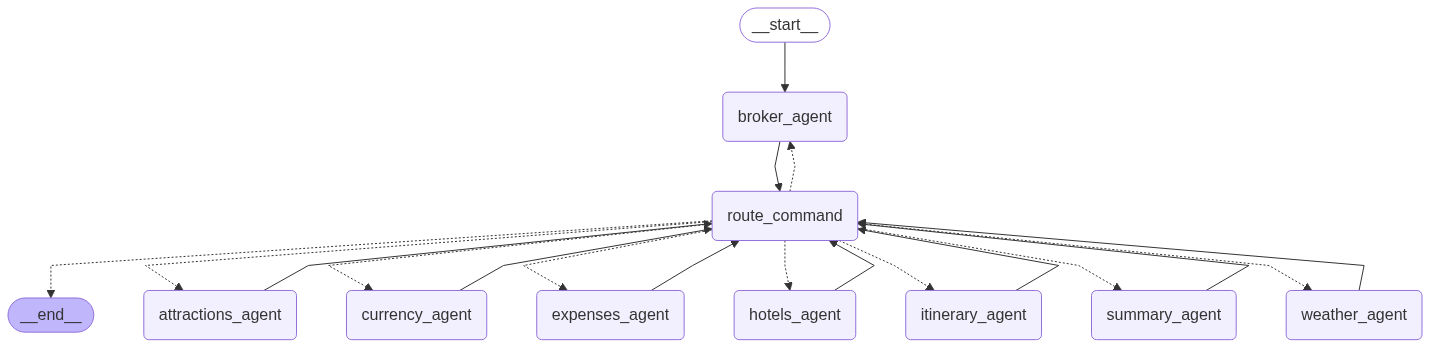

{'city': '', 'start_date': '', 'days': 0, 'budget_range': (0, 0), 'user_currency': 'USD', 'current_weather': Weather(date='2025-07-05', temperature=20.0, condition='Clear'), 'weather_forecast': [], 'attractions': [], 'restaurants': [], 'activities': [], 'transportation': Transportation(mode='None', cost_per_day=0.0), 'hotel': Hotel(name='None', daily_rate=0.0, rating=0.0), 'hotel_cost': 0.0, 'itinerary': [], 'daily_costs': [], 'total_cost_local': 0.0, 'daily_budget_local': 0.0, 'total_cost_user': 0.0, 'daily_budget_user': 0.0, 'summary': TripSummary(city='', start_date='', days=0, summary=''), 'session_id': 'd1e6e941-0018-490b-b395-e1ff120e5a96', 'history': [{'city': '', 'start_date': '', 'days': 0, 'budget_range': (0, 0), 'user_currency': 'USD', 'current_weather': {'date': '2025-07-05', 'temperature': 20.0, 'condition': 'Clear'}, 'weather_forecast': [], 'attractions': [], 'restaurants': [], 'activities': [], 'transportation': {'mode': 'None', 'cost_per_day': 0.0}, 'hotel': {'name': 'N

In [27]:
# Example Usage
if __name__ == "__main__":
    planner_graph = TravelPlannerGraph()
    command = Command(
        command_type="plan_trip",
        update=None,
        goto="broker_agent",
        payload={
            "city": "Paris",
            "start_date": "2025-07-10",
            "days": 3,
            "budget_range": (100, 200),
            "user_currency": "USD"
        },
        sender="user",
        recipient="broker_agent"
    )
    result = planner_graph.execute_command(command)
    print(result)